In [1]:
import os
import cv2
import numpy as np
import torch
import random

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import matplotlib.pyplot as plt


In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def compute_metrics(pred, target, threshold=0.5):
    """
    Compute IoU and Dice for binary masks.
    """
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    # Check if both prediction and target are empty.
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice



In [3]:
dataset_path = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")

In [4]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm.models.vision_transformer
import numpy as np

class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        self.global_pool = global_pool
        self.decoder = VIT_MLAHead(mla_channels=self.embed_dim,num_classes=self.num_classes)
        
        self.segmentation_head = SegmentationHead(
            in_channels=16,
            out_channels=self.num_classes,
            kernel_size=3,
        )
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim) 
            del self.norm  # remove the original norm

    def forward_features(self, x):
        B,C,H,W = x.shape
        x = self.patch_embed(x)
        _H,_W = H //self.patch_embed.patch_size[0],W //self.patch_embed.patch_size[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        featureskip = []
        featureskipnum = 1
        for blk in self.blocks:
            x = blk(x)
            if featureskipnum%(len(self.blocks)//4)==0: 
                featureskip.append(x[:,1:,:])
                # print(featureskipnum)
            featureskipnum += 1
        
        x = self.decoder(featureskip[0],featureskip[1],featureskip[2],featureskip[3],h=_H,w=_W)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        return x

class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        # print(x.shape,skip.shape)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.up(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class DecoderCup(nn.Module):
    def __init__(self):
        super().__init__()
        # self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            1024,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        
        decoder_channels = (256,128,64,16)


        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        # if self.config.n_skip != 0:
        #     skip_channels = self.config.skip_channels
        #     for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
        #         skip_channels[3-i]=0
        # else:
        #     skip_channels=[0,0,0,0]
        skip_channels=[512,256,128,64]
        self.conv_feature1 = Conv2dReLU(1024,skip_channels[0],kernel_size=3,padding=1,use_batchnorm=True)
        self.conv_feature2 = Conv2dReLU(1024,skip_channels[1],kernel_size=3,padding=1,use_batchnorm=True)
        self.up2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv_feature3 = Conv2dReLU(1024,skip_channels[2],kernel_size=3,padding=1,use_batchnorm=True)
        self.up3 = nn.UpsamplingBilinear2d(scale_factor=4)
        self.conv_feature4 = Conv2dReLU(1024,skip_channels[3],kernel_size=3,padding=1,use_batchnorm=True)
        self.up4 = nn.UpsamplingBilinear2d(scale_factor=8)

        # skip_channels=[128,64,32,8]
        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def TransShape(self,x,head_channels = 512,up=0):
        B, n_patch, hidden = x.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)

        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        if up==0:
            x = self.conv_feature1(x)
        elif up==1:
            x = self.conv_feature2(x)
            x = self.up2(x)
        elif up==2:
            x = self.conv_feature3(x)
            x = self.up3(x)
        elif up==3:
            x = self.conv_feature4(x)
            x = self.up4(x)
        return x

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        skip_channels=[512,256,128,64]
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = self.TransShape(features[i],head_channels=skip_channels[i],up=i)
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


class MLAHead(nn.Module):
    def __init__(self, mla_channels=256, mlahead_channels=128, norm_cfg=None):
        super(MLAHead, self).__init__()
        self.head2 = nn.Sequential(nn.Conv2d(mla_channels, mlahead_channels, 3, padding=1, bias=False),
                                   nn.BatchNorm2d(mlahead_channels), nn.ReLU(),
            nn.Conv2d(
                                       mlahead_channels, mlahead_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mlahead_channels), nn.ReLU())
        self.head3 = nn.Sequential(nn.Conv2d(mla_channels, mlahead_channels, 3, padding=1, bias=False),
                                   nn.BatchNorm2d(mlahead_channels), nn.ReLU(),
            nn.Conv2d(
                                       mlahead_channels, mlahead_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mlahead_channels), nn.ReLU())
        self.head4 = nn.Sequential(nn.Conv2d(mla_channels, mlahead_channels, 3, padding=1, bias=False),
                                   nn.BatchNorm2d(mlahead_channels), nn.ReLU(),
            nn.Conv2d(
                                       mlahead_channels, mlahead_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mlahead_channels), nn.ReLU())
        self.head5 = nn.Sequential(nn.Conv2d(mla_channels, mlahead_channels, 3, padding=1, bias=False),
                                   nn.BatchNorm2d(mlahead_channels), nn.ReLU(),
            nn.Conv2d(
                                       mlahead_channels, mlahead_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mlahead_channels), nn.ReLU())

    def forward(self, mla_p2, mla_p3, mla_p4, mla_p5):
        head2 = F.interpolate(self.head2(
            mla_p2), (4*mla_p2.shape[-2],4*mla_p2.shape[-1]), mode='bilinear', align_corners=True) 
        head3 = F.interpolate(self.head3(
            mla_p3), (4*mla_p3.shape[-2],4*mla_p3.shape[-1]), mode='bilinear', align_corners=True)
        head4 = F.interpolate(self.head4(
            mla_p4), (4*mla_p4.shape[-2],4*mla_p4.shape[-1]), mode='bilinear', align_corners=True)
        head5 = F.interpolate(self.head5(
            mla_p5), (4*mla_p5.shape[-2],4*mla_p5.shape[-1]), mode='bilinear', align_corners=True)
        return torch.cat([head2, head3, head4, head5], dim=1)


class VIT_MLAHead(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=768, mla_channels=256, mlahead_channels=128,num_classes=6,
                 norm_layer=nn.BatchNorm2d, norm_cfg=None, **kwargs):
        super(VIT_MLAHead, self).__init__(**kwargs)
        self.img_size = img_size
        self.norm_cfg = norm_cfg
        self.mla_channels = mla_channels
        self.BatchNorm = norm_layer
        self.mlahead_channels = mlahead_channels
        self.num_classes = num_classes
        self.mlahead = MLAHead(mla_channels=self.mla_channels,
                               mlahead_channels=self.mlahead_channels, norm_cfg=self.norm_cfg)
        self.cls = nn.Conv2d(4 * self.mlahead_channels,
                             self.num_classes, 3, padding=1)

    def forward(self, x1,x2,x3,x4,h=14,w=14):
        B,n_patch,hidden = x1.size()
        if h==w:
            h,w = int(np.sqrt(n_patch)),int(np.sqrt(n_patch))
        x1 = x1.permute(0,2,1)
        x1 = x1.contiguous().view(B,hidden,h,w)
        x2 = x2.permute(0,2,1)
        x2 = x2.contiguous().view(B,hidden,h,w)
        x3 = x3.permute(0,2,1)
        x3 = x3.contiguous().view(B,hidden,h,w)
        x4 = x4.permute(0,2,1)
        x4 = x4.contiguous().view(B,hidden,h,w)
        x = self.mlahead(x1,x2,x3,x4)
        x = self.cls(x)
        x = F.interpolate(x, size=(h*16,w*16), mode='bilinear',
                          align_corners=True)
        return x


def mae_vit_small_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=6, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import argparse
import pathlib
import torch

model_SFM = vit_large_patch16(in_chans=1, global_pool=False, num_classes=2)
device = torch.device('cuda')

with torch.serialization.safe_globals([argparse.Namespace, pathlib.PosixPath]):
    checkpoint = torch.load('/home/dmatveev/workdir/rosneft_segmentation/models/SFM-Large.pth', map_location=device)

msg = model_SFM.load_state_dict(checkpoint['model'], strict=False)
print(msg)


_IncompatibleKeys(missing_keys=['head.weight', 'head.bias', 'decoder.mlahead.head2.0.weight', 'decoder.mlahead.head2.1.weight', 'decoder.mlahead.head2.1.bias', 'decoder.mlahead.head2.1.running_mean', 'decoder.mlahead.head2.1.running_var', 'decoder.mlahead.head2.3.weight', 'decoder.mlahead.head2.4.weight', 'decoder.mlahead.head2.4.bias', 'decoder.mlahead.head2.4.running_mean', 'decoder.mlahead.head2.4.running_var', 'decoder.mlahead.head3.0.weight', 'decoder.mlahead.head3.1.weight', 'decoder.mlahead.head3.1.bias', 'decoder.mlahead.head3.1.running_mean', 'decoder.mlahead.head3.1.running_var', 'decoder.mlahead.head3.3.weight', 'decoder.mlahead.head3.4.weight', 'decoder.mlahead.head3.4.bias', 'decoder.mlahead.head3.4.running_mean', 'decoder.mlahead.head3.4.running_var', 'decoder.mlahead.head4.0.weight', 'decoder.mlahead.head4.1.weight', 'decoder.mlahead.head4.1.bias', 'decoder.mlahead.head4.1.running_mean', 'decoder.mlahead.head4.1.running_var', 'decoder.mlahead.head4.3.weight', 'decoder.ml

In [14]:
model_SFM

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

In [8]:
sam2_checkpoint = "/home/dmatveev/workdir/rosneft_segmentation/models/sam2.1_hiera_base_plus.pt"  # Path to model weights
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"       # путь к конфигу с префиксом file://

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [15]:
all_files = sorted(os.listdir(seismic_dir))
val_files = all_files[:10]

File: 0.dat, IoU: 1.0000, Dice: 1.0000


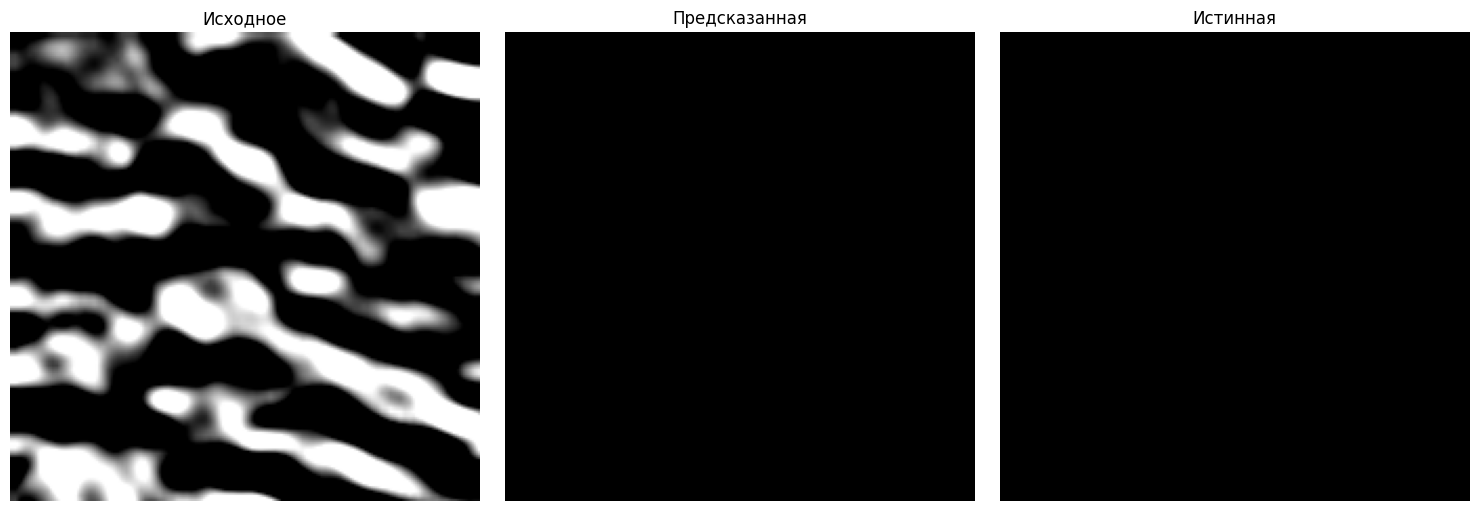

File: 1.dat, IoU: 0.6326, Dice: 0.7749


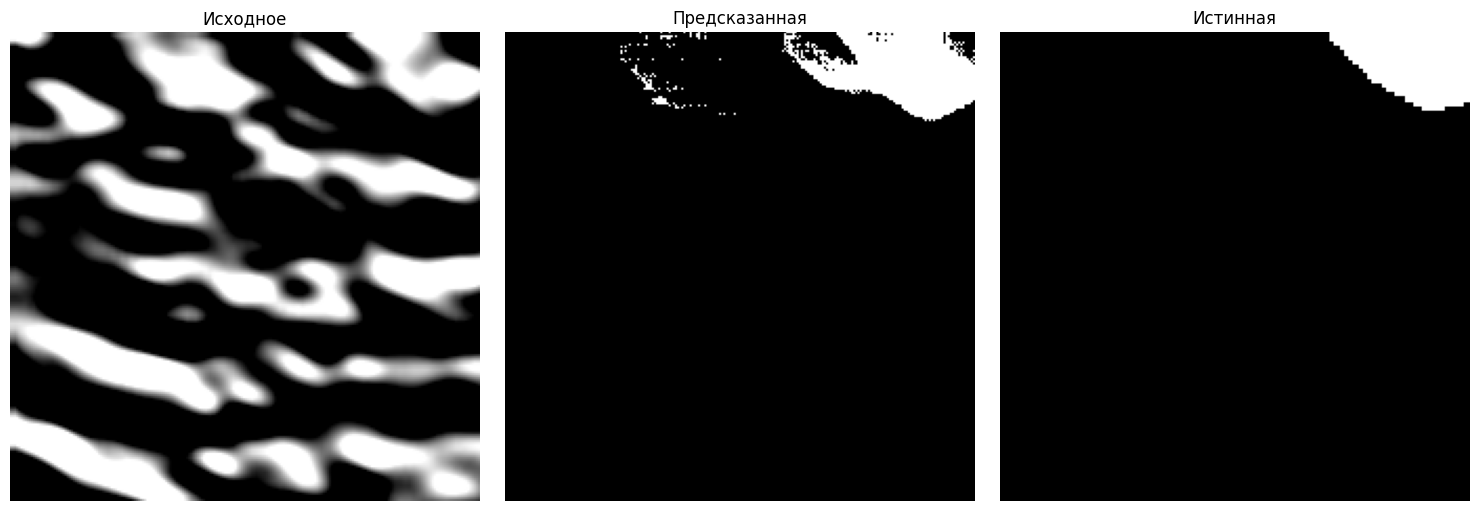

File: 10.dat, IoU: 0.7371, Dice: 0.8487


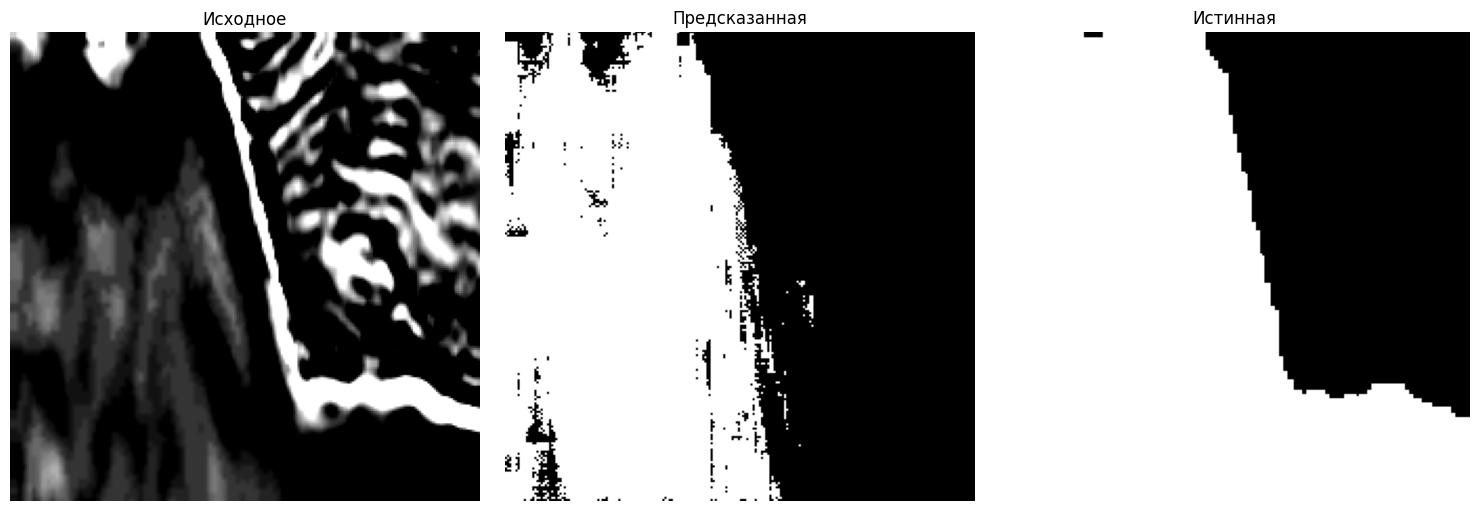

File: 100.dat, IoU: 1.0000, Dice: 1.0000


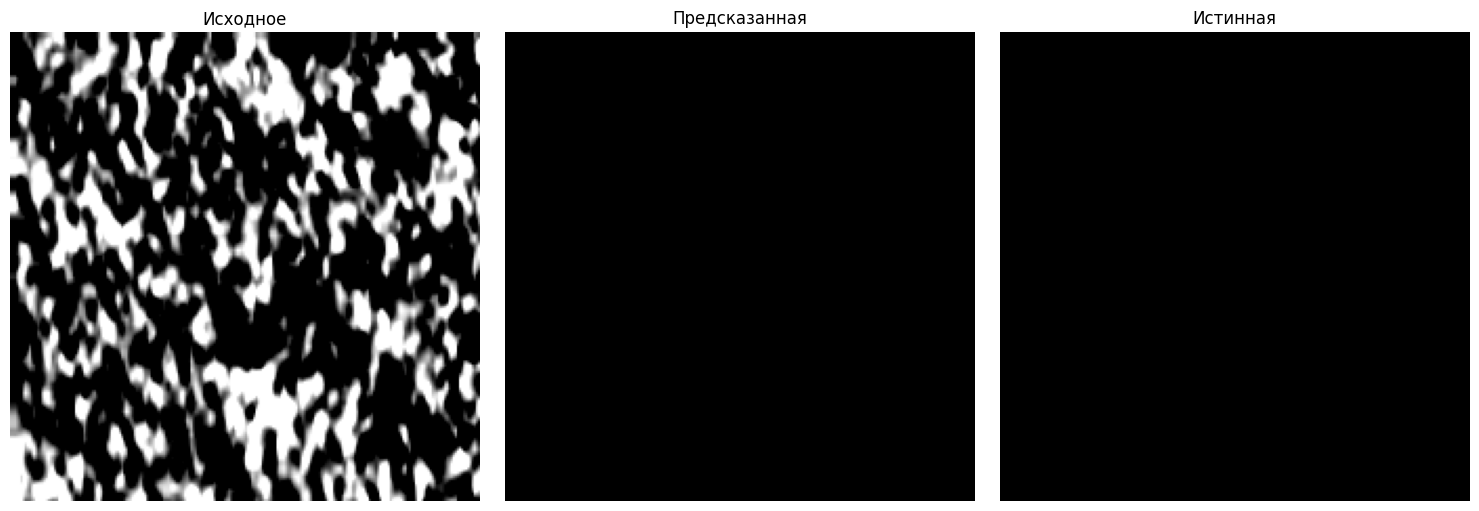

File: 1000.dat, IoU: 0.6394, Dice: 0.7801


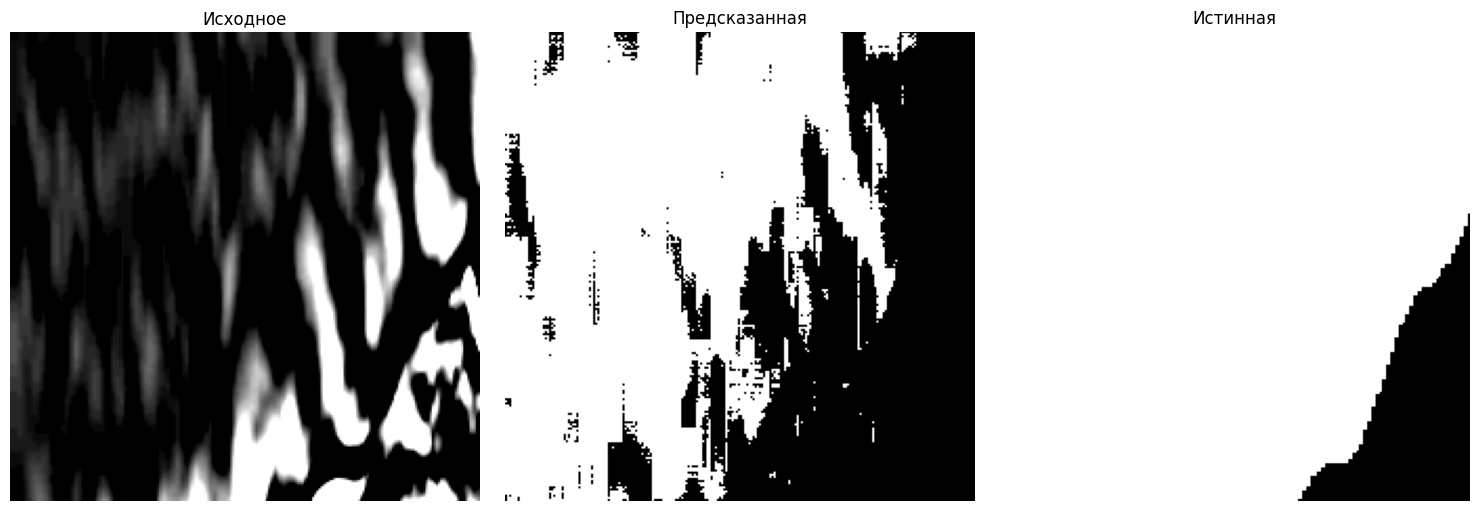

File: 1001.dat, IoU: 0.4221, Dice: 0.5936


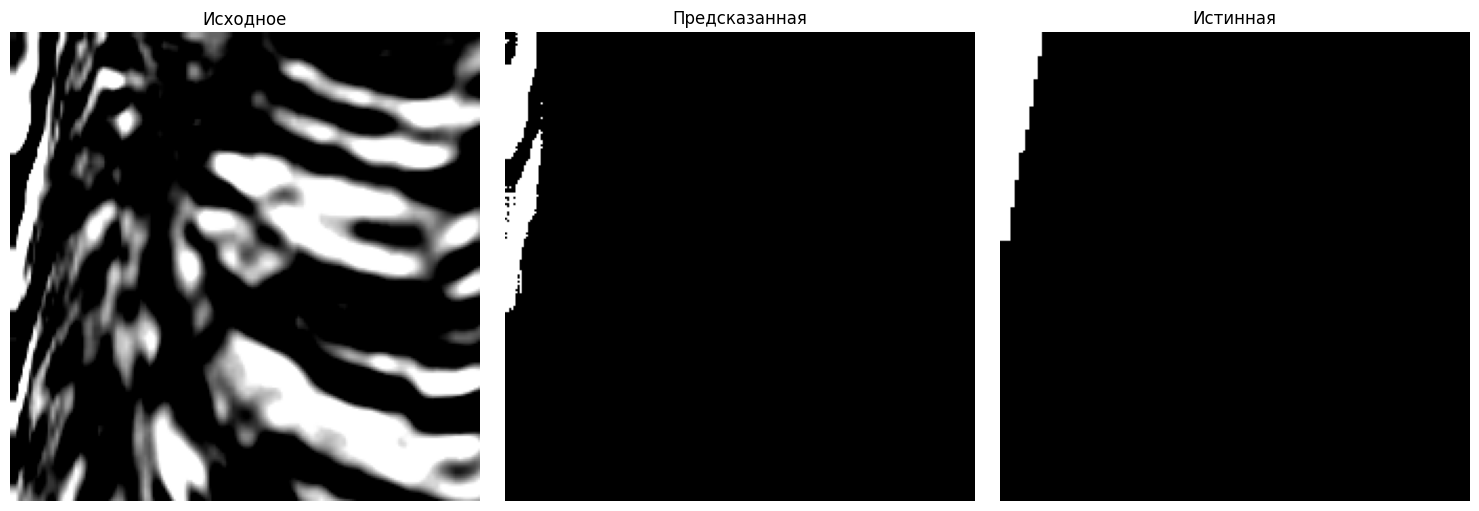

File: 1002.dat, IoU: 0.6540, Dice: 0.7908


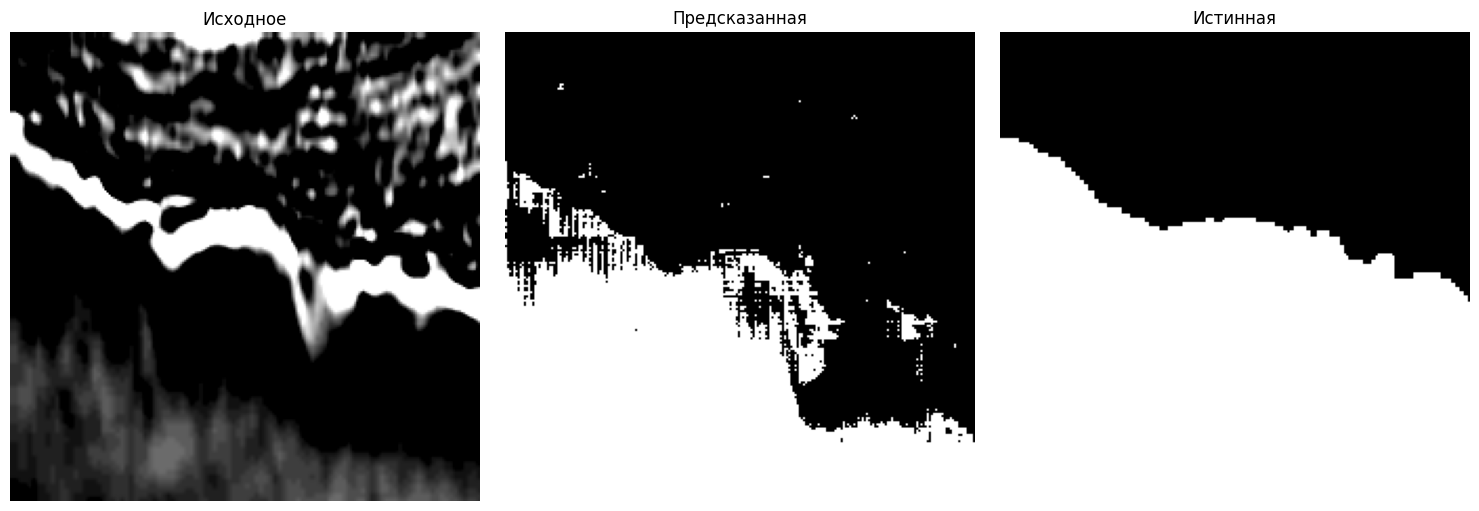

File: 1003.dat, IoU: 0.1590, Dice: 0.2743


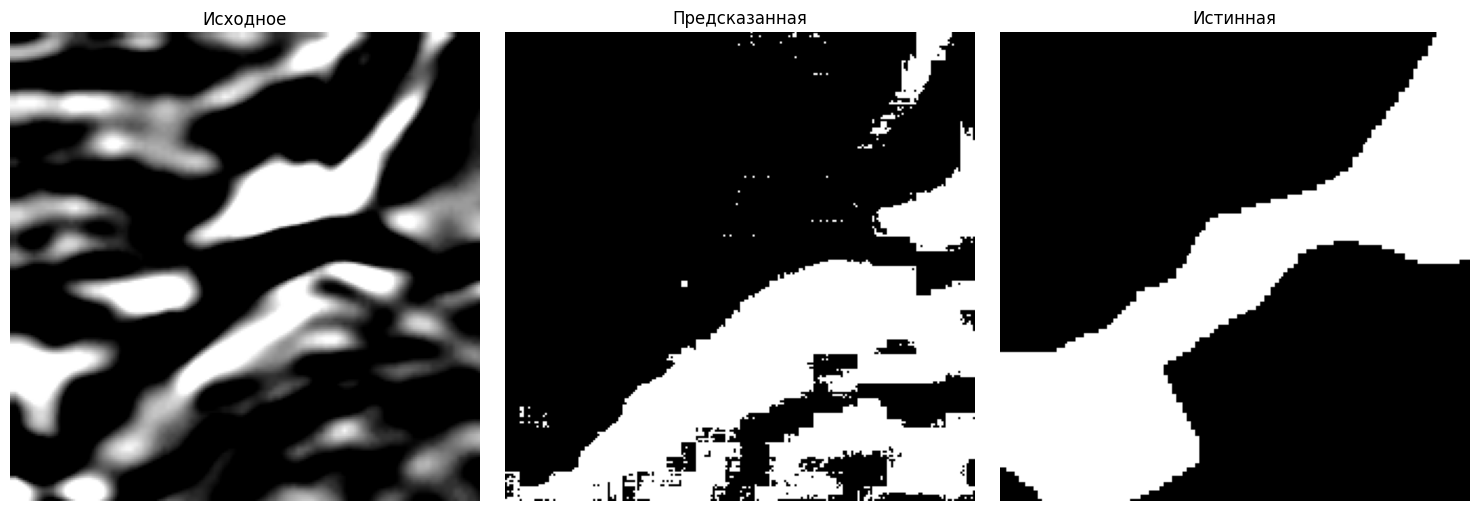

File: 1004.dat, IoU: 0.9145, Dice: 0.9554


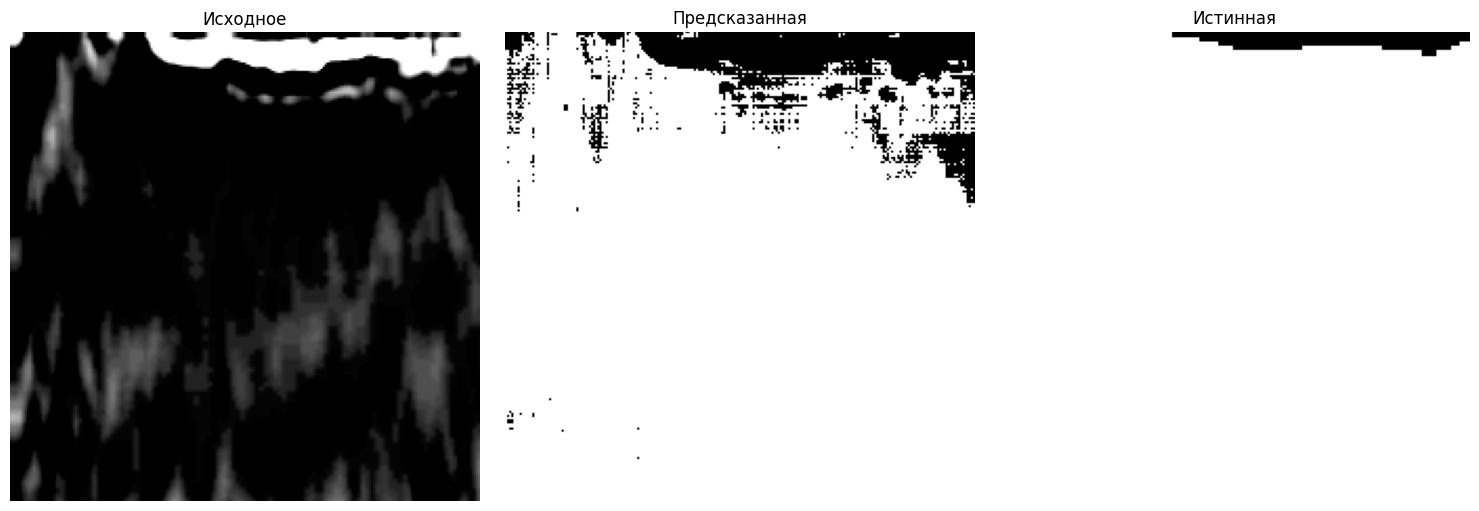

File: 1005.dat, IoU: 0.2966, Dice: 0.4575


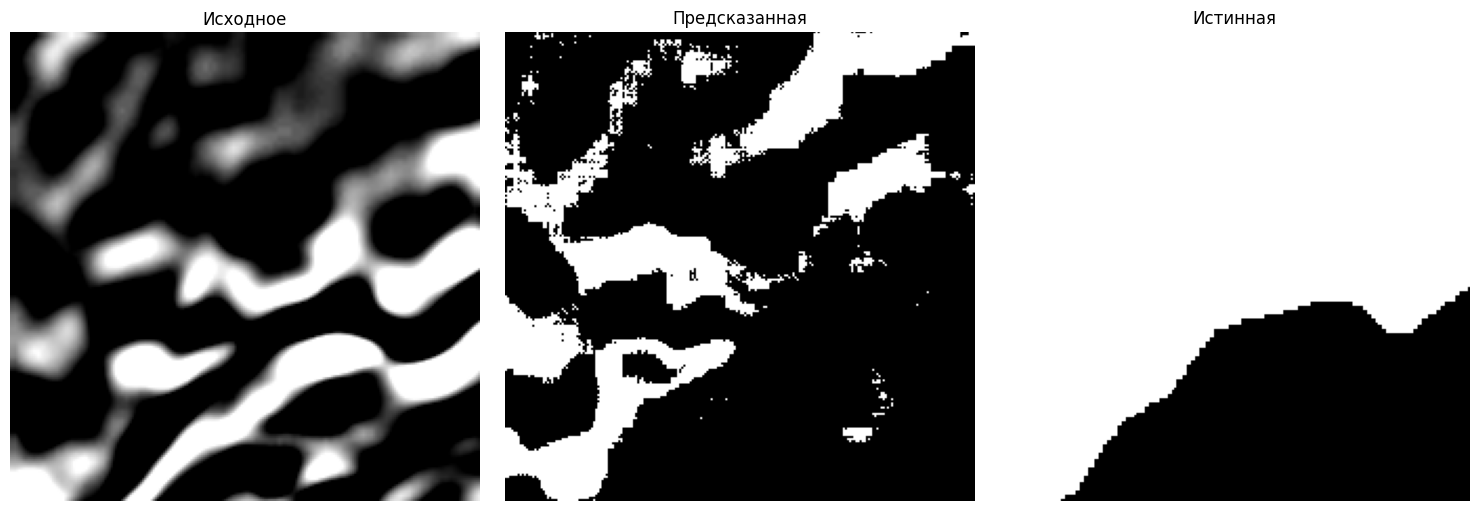

In [14]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Предполагаем, что имя файла такое же

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если исходное изображение одноканальное, дублируем канал для создания 3-канального изображения
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    predictor.set_image(seismic_img)

    # Get a random point from the ground truth mask as prompt.
    # Assumes non-zero pixels are the object of interest.
    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)
        # SAM usually expects point coordinates as (x, y) (i.e. column, row)
        prompt_point = np.array([[chosen_idx[1], chosen_idx[0]]], dtype=np.float32)
        point_label = np.array([1], dtype=np.int32)  # Positive prompt
        # Call predict with point prompt
        masks, scores, logits = predictor.predict(point_coords=prompt_point, point_labels=point_label)
    else:
        # Fallback to a prediction without prompt if no positive points found
        masks, scores, logits = predictor.predict()

    if len(masks) > 0:
        pred_mask = masks[0]
    else:
        pred_mask = np.zeros_like(label)

    # Resize predicted mask to match the label size
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))

    # Compute metrics
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)

    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Visualization: original image, predicted mask, and ground truth mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(seismic_img, cmap='gray')
    axes[0].set_title("Исходное")
    axes[0].axis('off')
    
    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Предсказанная")
    axes[1].axis('off')
    
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title("Истинная")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [11]:
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)

print(f"\nAverage IoU over validation set: {avg_iou:.4f}")
print(f"Average Dice coefficient over validation set: {avg_dice:.4f}")


Average IoU over validation set: 0.5954
Average Dice coefficient over validation set: 0.6634


In [23]:
model_SFM.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

File: 0.dat, IoU: 0.0000, Dice: 0.0000


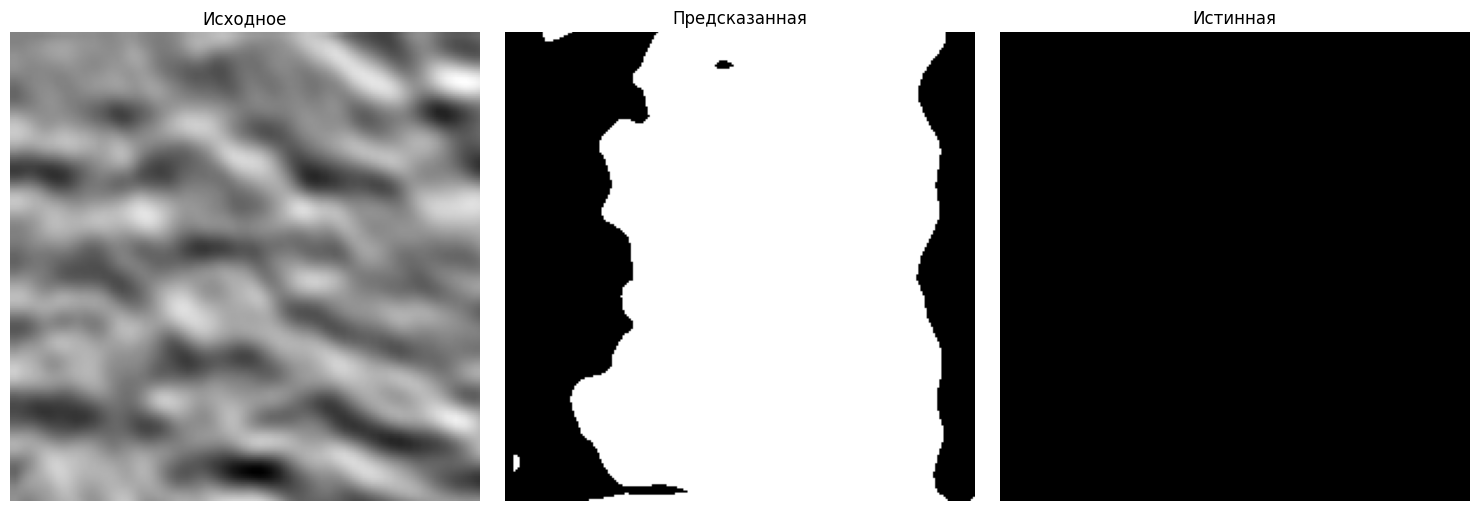

File: 1.dat, IoU: 0.0195, Dice: 0.0383


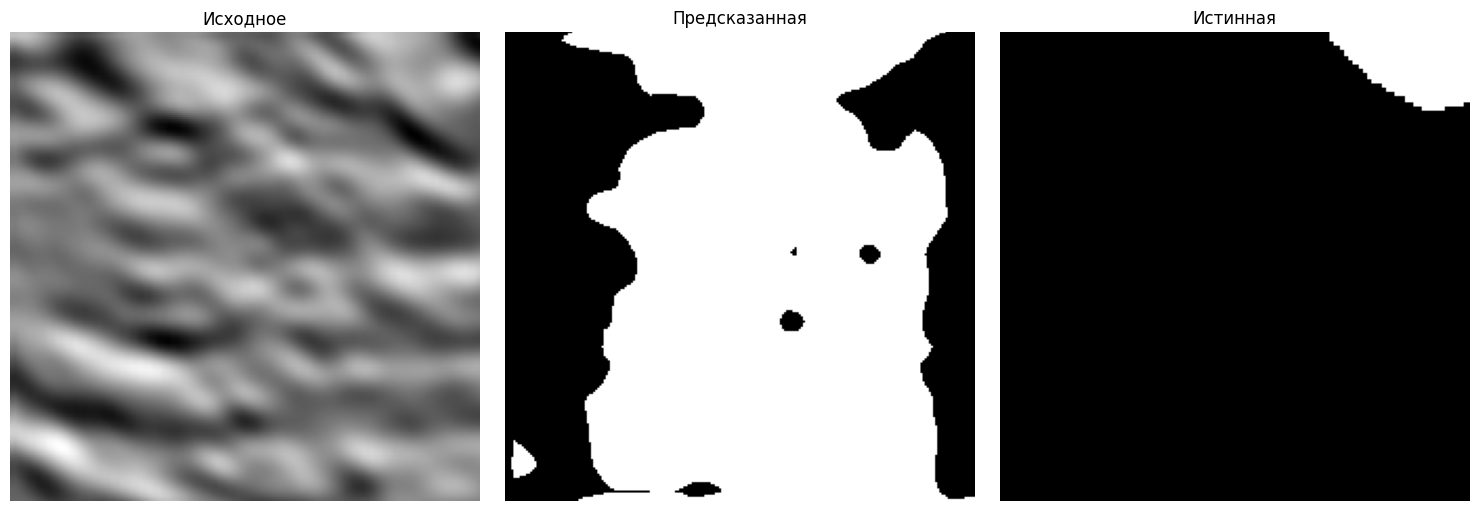

File: 10.dat, IoU: 0.5002, Dice: 0.6669


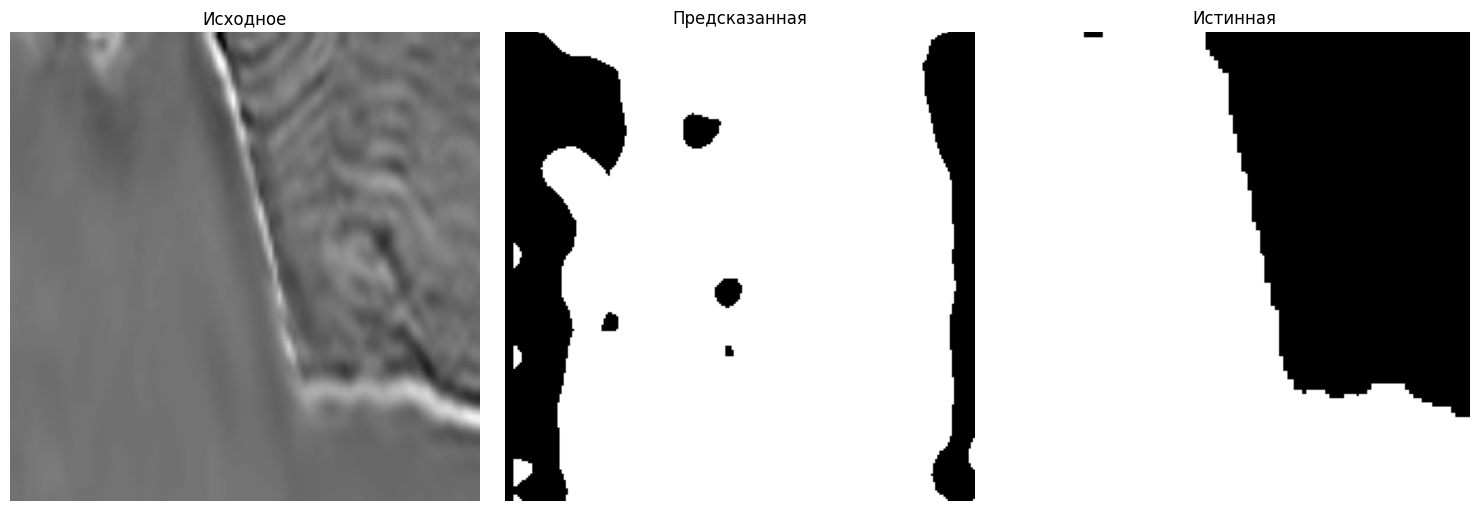

File: 100.dat, IoU: 0.0000, Dice: 0.0000


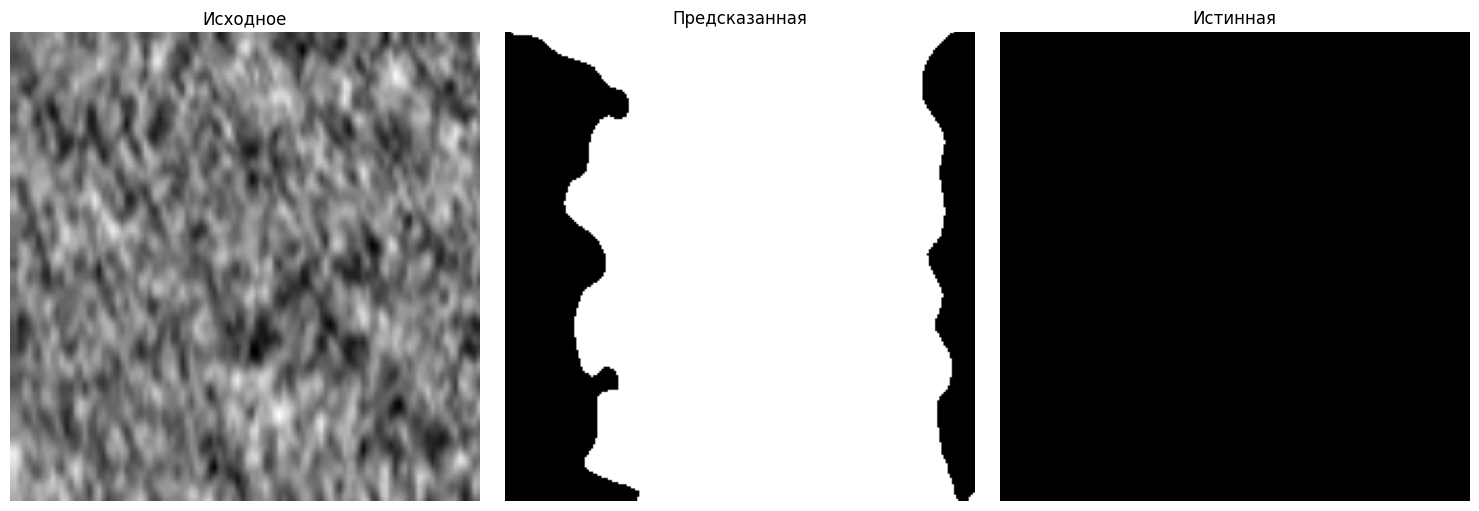

File: 1000.dat, IoU: 0.8038, Dice: 0.8912


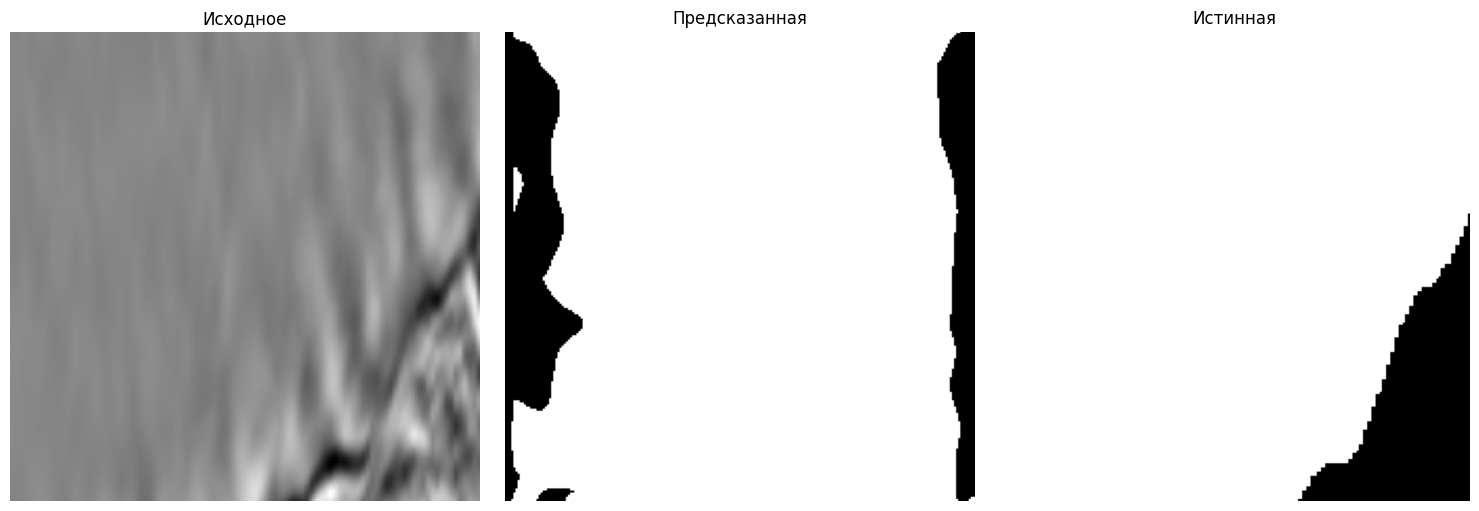

File: 1001.dat, IoU: 0.0021, Dice: 0.0042


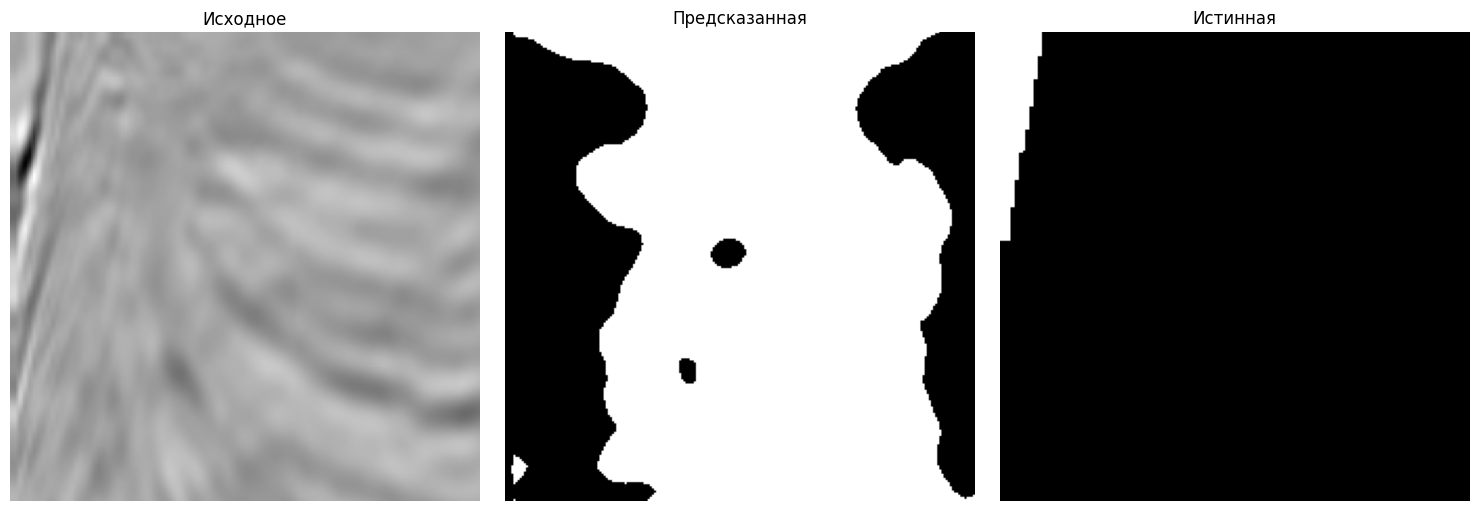

File: 1002.dat, IoU: 0.4533, Dice: 0.6239


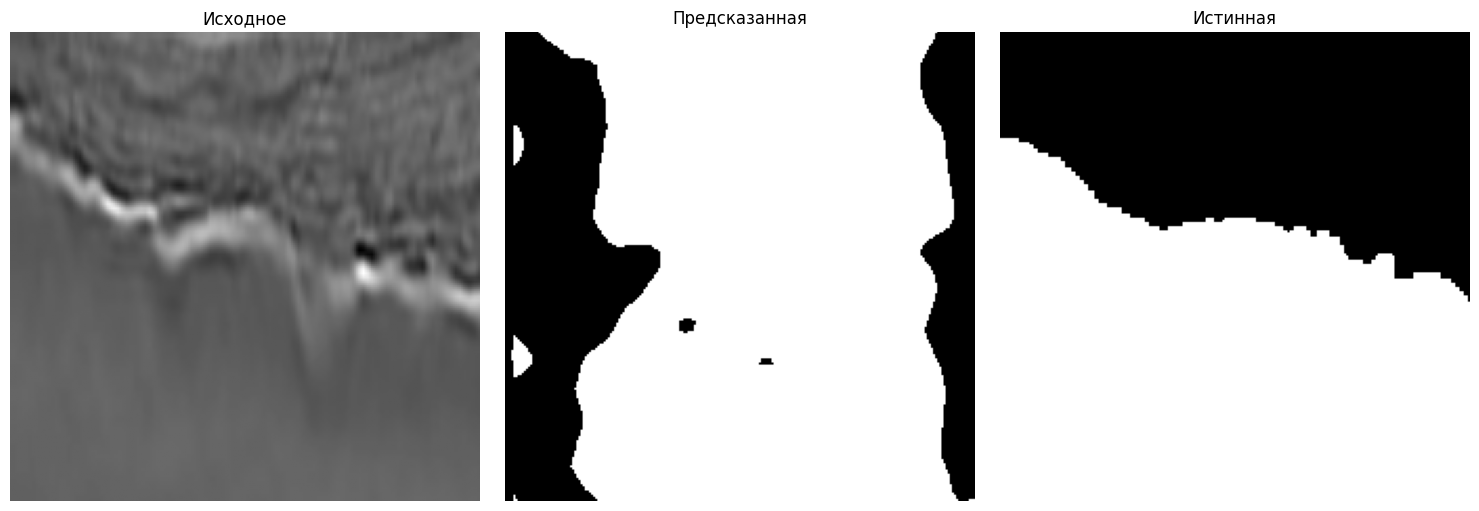

File: 1003.dat, IoU: 0.2163, Dice: 0.3557


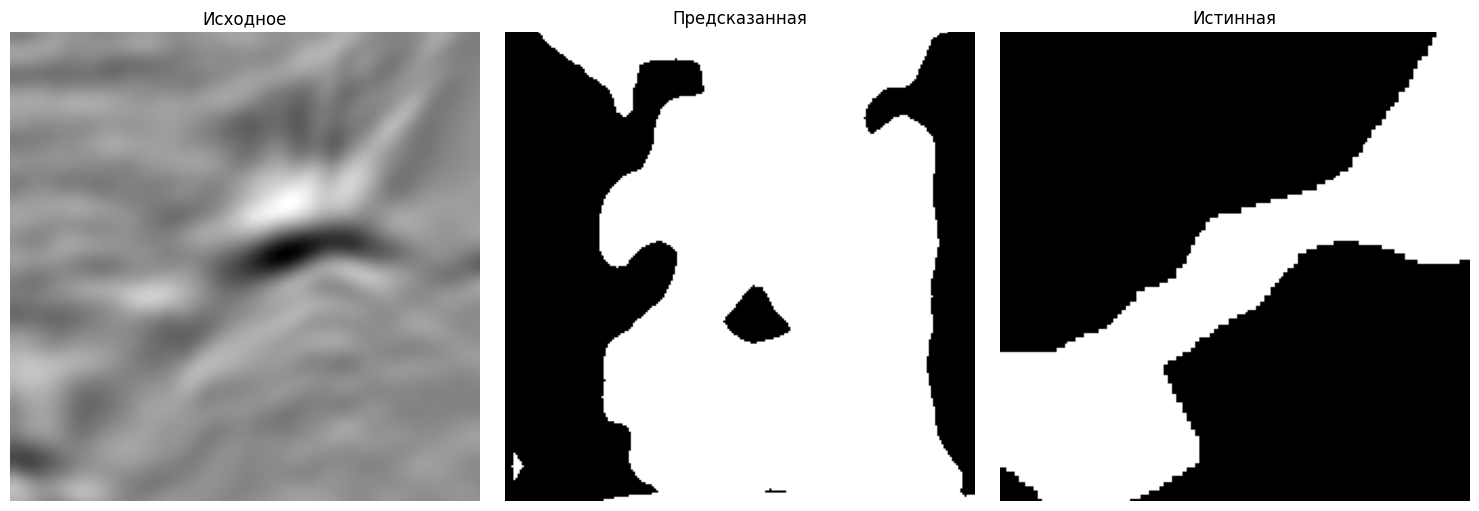

File: 1004.dat, IoU: 0.6871, Dice: 0.8145


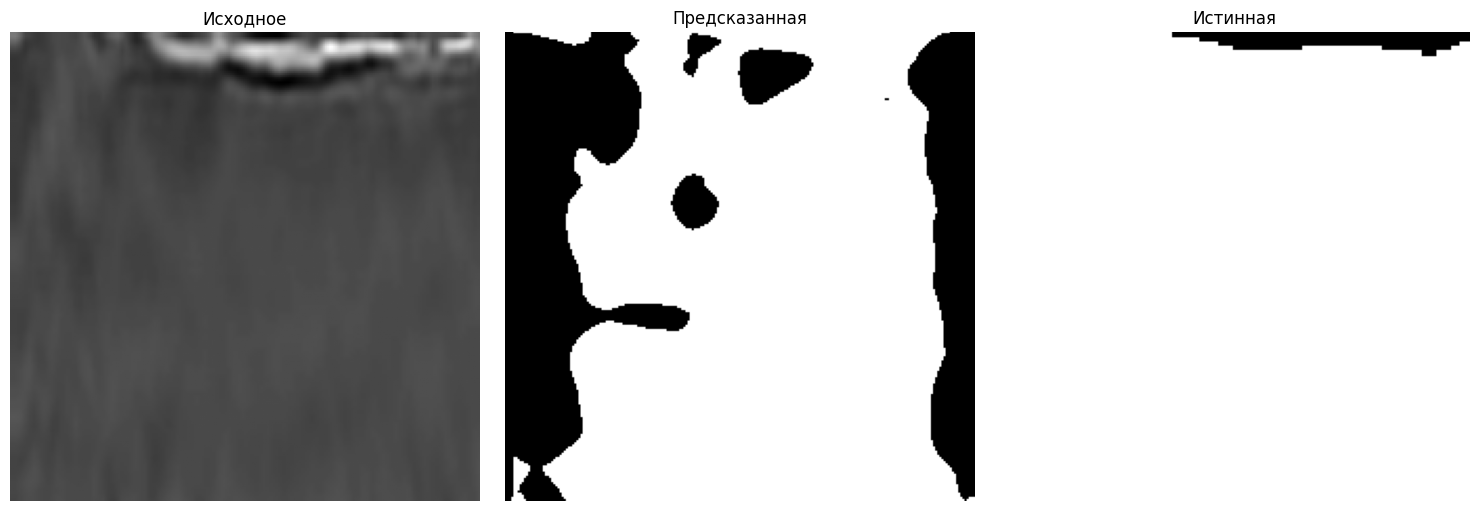

File: 1005.dat, IoU: 0.4598, Dice: 0.6300


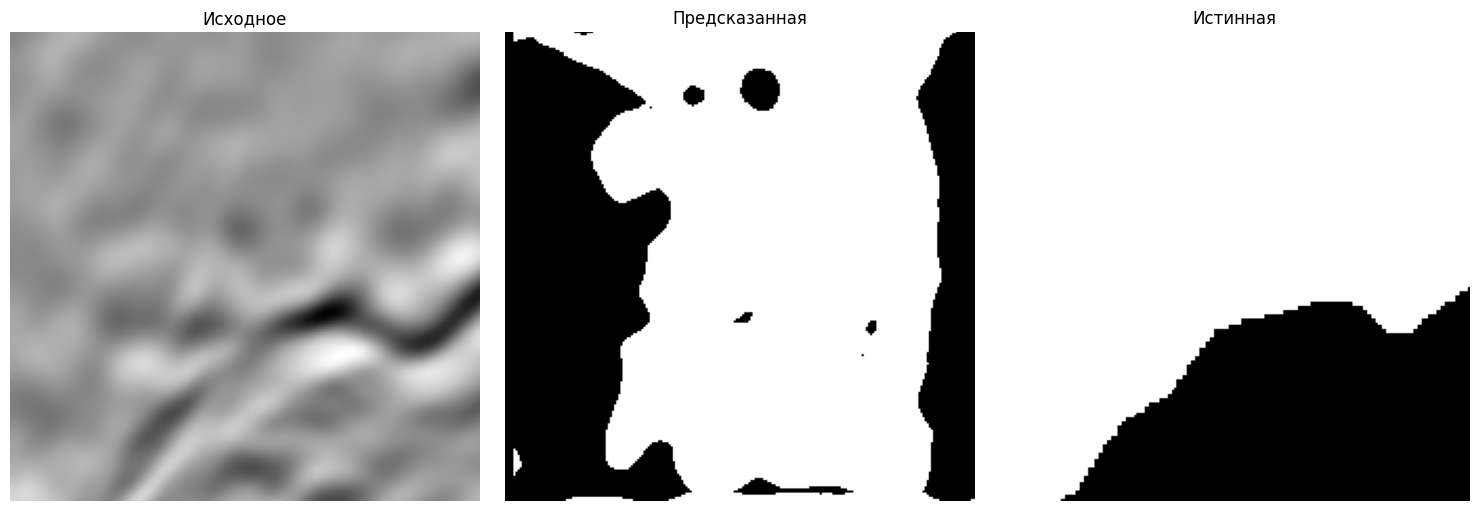

In [24]:
model_SFM.eval()  # Set the model to evaluation mode

ious = []
dices = []

# Loop through your validation files
for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Assumes same filename for label

    seismic = load_dat_file(seismic_path)  # e.g., returns a numpy array (H, W)
    label   = load_dat_file(label_path)    # ground truth segmentation mask

    # For SFM, we expect a single-channel input.
    # If the seismic image is 2D, we can use it directly.
    if seismic.ndim == 2:
        seismic_input = seismic.astype(np.float32)
    else:
        # Otherwise, select one channel if needed.
        seismic_input = seismic[..., 0].astype(np.float32)

    # Convert input to a torch tensor and add batch/channel dimensions: (1, 1, H, W)
    input_tensor = torch.from_numpy(seismic_input).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        # Run inference
        output = model_SFM(input_tensor)
        # Assuming output has shape (B, num_classes, H, W), take argmax over classes:
        pred = output.argmax(dim=1).squeeze(0).cpu().numpy()

    # If the output size does not match the label, resize the prediction (using nearest-neighbor)
    if pred.shape != label.shape:
        pred = cv2.resize(pred.astype(np.uint8), (label.shape[1], label.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute metrics (IoU and Dice)
    iou, dice = compute_metrics(pred, label)
    ious.append(iou)
    dices.append(dice)

    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Visualization: display the original seismic image, predicted mask, and ground truth mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(seismic, cmap='gray')
    axes[0].set_title("Исходное")
    axes[0].axis('off')
    
    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title("Предсказанная")
    axes[1].axis('off')
    
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title("Истинная")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)

print(f"\nAverage IoU over validation set: {avg_iou:.4f}")
print(f"Average Dice coefficient over validation set: {avg_dice:.4f}")


Average IoU over validation set: 0.4182
Average Dice coefficient over validation set: 0.4866
